In [1]:
%load_ext tensorboard

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib
import copy
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as plot
import seaborn as sns
import matplotlib.lines as mlines
import semantic_drift
import tensorflow as tf
import utils
import two_models_exp as tm
import pickle

In [137]:
#mnist
MULTI_NUM = 2

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test_orig) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
import importlib
importlib.reload(tm)
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [140]:
#load pretrained model
with open('swarm_exp/hist/pretrained_model_2nn_mnist_local_updates_epochs_20_data_600.pickle', 'rb') as handle:
    init_weights = pickle.load(handle)

In [151]:
x_target, y_target_orig = utils.filter_data_by_labels_with_numbers(x_test,
                                             y_test_orig, 
                                             {2:1000, 3:1000})
y_target = keras.utils.to_categorical(y_target_orig, 10)

In [152]:
my_model = get_model()
my_model.set_weights(init_weights)
compile_model(my_model)
my_model.evaluate(x_target, y_target)

2000/2000 [==============================] - 0s 33us/sample - loss: 0.0187 - acc: 0.8715


[0.018669994592666626, 0.8715]

In [9]:
import swarm_exp.data_process as utils

In [24]:
label_conf = {}
for i in range(6):
    label_conf[i] = 10000
x_test, y_test_orig = utils.filter_data_by_labels_with_numbers(x_test,
                                             y_test_orig, 
                                             label_conf)

In [25]:
np.unique(y_test_orig)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [135]:
import swarm_exp.data_process as dp

In [15]:
def count_occ(arr):
    y = np.bincount(arr)
    ii = np.nonzero(y)[0]
    return dict(zip(ii,y[ii]))

In [136]:
data_provider = dp.DataProvider(x_train, y_train)

In [66]:
count_occ(data_provider.y_train[data_provider.mask_unused])

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [101]:
size = 500

x_train_list = []
y_train_list = []
x_target, y_target_orig = data_provider.fetch({0:80,1:80})
# candidates = np.arange(0,10)
# np.random.shuffle(candidates)
def append_data(x_train_list, y_train_list, local_data_labels):
    label_conf = {}
    for j in local_data_labels:
        label_conf[j] = 80

    x, y = data_provider.fetch(label_conf)
    x_train_list.append(x)
    y_train_list.append(y)

def append_series(x_train_list, y_train_list, num):
    for _ in range(num):
        for __ in range(10):
            append_data(x_train_list, y_train_list, [2,3])
        for __ in range(10):
            append_data(x_train_list, y_train_list, [4,5])

In [102]:
append_series(x_train_list, y_train_list, 4)

In [103]:
y_train_list = [keras.utils.to_categorical(y, 10) for y in y_train_list]

In [69]:
y_target = keras.utils.to_categorical(y_target_orig, 10)

In [29]:
y_test = keras.utils.to_categorical(y_test_orig, 10)

In [12]:
label_conf = {}
for i in local_data_labels:
    label_conf[i] = 100
x_val, y_val_orig = utils.filter_data_by_labels_with_numbers(x_train,
                                             y_train, 
                                             label_conf)

In [13]:
y_val = keras.utils.to_categorical(y_val_orig, 10)

In [70]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [37]:
get_model = tm.custom_model

In [83]:
model_weights_list = []
for i in range(20):
    new_model = get_model()
    new_model.set_weights(init_weights)
    compile_model(new_model)
#     new_model.fit(x_train_list[i], y_train_list[i], epochs=10, shuffle=True,
#                  validation_data=(x_val, y_val))
    model_weights_list.append(copy.deepcopy(new_model.get_weights()))
    del new_model

In [201]:
init_weights = get_model().get_weights()

In [106]:
# Control Group - ONLY LOCAL
assim_epochs = 4
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    target_model.fit(x_target, y_target, epochs=assim_epochs, shuffle=True)
#     target_model.fit(x_train_list[0], y_train_list[0], epochs=assim_epochs, shuffle=True)
    hist = target_model.evaluate(x_test, y_test)
    print("--------------{}".format(hist))
    eval_hist.append(copy.deepcopy(hist))
    cur_weights = copy.deepcopy(target_model.get_weights())
    K.clear_session()

6030/6030 [==============================] - 0s 42us/sample - loss: 0.0809 - acc: 0.5299
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 415us/sample - loss: 0.0833 - acc: 0.5063
Epoch 2/4
160/160 [==============================] - 0s 129us/sample - loss: 0.0805 - acc: 0.5688
Epoch 3/4
160/160 [==============================] - 0s 117us/sample - loss: 0.0778 - acc: 0.5938
Epoch 4/4
6030/6030 [==============================] - 0s 35us/sample - loss: 0.0777 - acc: 0.4070
--------------[0.07774569557031391, 0.40696517]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 287us/sample - loss: 0.0728 - acc: 0.6125
Epoch 2/4
160/160 [==============================] - 0s 55us/sample - loss: 0.0707 - acc: 0.6125
Epoch 3/4
160/160 [==============================] - 0s 46us/sample - loss: 0.0688 - acc: 0.6125
Epoch 4/4
6030/6030 [==============================] - 0s 20us/sample - loss: 0.0767 - acc: 0.3504
---------

160/160 [==============================] - 0s 68us/sample - loss: 0.0339 - acc: 0.7937
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.1033 - acc: 0.2950
--------------[0.1032653338898276, 0.29502487]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 402us/sample - loss: 0.0338 - acc: 0.7812
Epoch 2/4
160/160 [==============================] - 0s 100us/sample - loss: 0.0330 - acc: 0.7812
Epoch 3/4
160/160 [==============================] - 0s 58us/sample - loss: 0.0329 - acc: 0.7937
Epoch 4/4
6030/6030 [==============================] - 0s 36us/sample - loss: 0.1043 - acc: 0.2881
--------------[0.10431457255066529, 0.2880597]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 402us/sample - loss: 0.0324 - acc: 0.7937
Epoch 2/4
160/160 [==============================] - 0s 108us/sample - loss: 0.0323 - acc: 0.8062
Epoch 3/4
160/160 [==============================] - 0s 56us/s

Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 402us/sample - loss: 0.0220 - acc: 0.8750
Epoch 2/4
160/160 [==============================] - 0s 112us/sample - loss: 0.0211 - acc: 0.8813
Epoch 3/4
160/160 [==============================] - 0s 69us/sample - loss: 0.0214 - acc: 0.8938
Epoch 4/4
6030/6030 [==============================] - 0s 31us/sample - loss: 0.1121 - acc: 0.2483
--------------[0.11205110071755167, 0.24825871]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 401us/sample - loss: 0.0209 - acc: 0.8875
Epoch 2/4
160/160 [==============================] - 0s 146us/sample - loss: 0.0209 - acc: 0.8813
Epoch 3/4
160/160 [==============================] - 0s 113us/sample - loss: 0.0211 - acc: 0.8813
Epoch 4/4
6030/6030 [==============================] - 0s 32us/sample - loss: 0.1127 - acc: 0.2448
--------------[0.11266634219865103, 0.24477611]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [=========

6030/6030 [==============================] - 0s 30us/sample - loss: 0.1179 - acc: 0.2308
--------------[0.11794217283749461, 0.23084576]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 449us/sample - loss: 0.0141 - acc: 0.9312
Epoch 2/4
160/160 [==============================] - 0s 51us/sample - loss: 0.0139 - acc: 0.9375
Epoch 3/4
160/160 [==============================] - 0s 164us/sample - loss: 0.0139 - acc: 0.9500
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.1182 - acc: 0.2343
--------------[0.118210769841327, 0.23432836]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 452us/sample - loss: 0.0137 - acc: 0.9438
Epoch 2/4
160/160 [==============================] - 0s 42us/sample - loss: 0.0136 - acc: 0.9438
Epoch 3/4
160/160 [==============================] - 0s 77us/sample - loss: 0.0136 - acc: 0.9438
Epoch 4/4
6030/6030 [==============================] - 0s 39us/

160/160 [==============================] - 0s 434us/sample - loss: 0.0102 - acc: 0.9563
Epoch 2/4
160/160 [==============================] - 0s 90us/sample - loss: 0.0101 - acc: 0.9625
Epoch 3/4
160/160 [==============================] - 0s 109us/sample - loss: 0.0102 - acc: 0.9500
Epoch 4/4
6030/6030 [==============================] - 0s 29us/sample - loss: 0.1222 - acc: 0.2290
--------------[0.12219864938587296, 0.22902156]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 456us/sample - loss: 0.0099 - acc: 0.9625
Epoch 2/4
160/160 [==============================] - 0s 64us/sample - loss: 0.0103 - acc: 0.9625
Epoch 3/4
160/160 [==============================] - 0s 52us/sample - loss: 0.0099 - acc: 0.9688
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.1223 - acc: 0.2290
--------------[0.12233728506968389, 0.22902156]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 411us

6030/6030 [==============================] - 0s 20us/sample - loss: 0.1256 - acc: 0.2216
--------------[0.1255875830577183, 0.22155887]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 410us/sample - loss: 0.0076 - acc: 0.9688
Epoch 2/4
160/160 [==============================] - 0s 83us/sample - loss: 0.0075 - acc: 0.9812
Epoch 3/4
160/160 [==============================] - 0s 53us/sample - loss: 0.0074 - acc: 0.9688
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.1258 - acc: 0.2221
--------------[0.125832062193608, 0.22205639]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 422us/sample - loss: 0.0078 - acc: 0.9750
Epoch 2/4
160/160 [==============================] - 0s 89us/sample - loss: 0.0073 - acc: 0.9750
Epoch 3/4
160/160 [==============================] - 0s 48us/sample - loss: 0.0073 - acc: 0.9750
Epoch 4/4
6030/6030 [==============================] - 0s 34us/sa

In [107]:
# ASSIMILATION - ONLY REMOTE
assim_epochs = 4
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist2 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    target_model.fit(x_train_list[i], y_train_list[i], epochs=assim_epochs, shuffle=True)
#     target_model.fit(x_target, y_target, epochs=assim_epochs, shuffle=True)
    hist = target_model.evaluate(x_test, y_test)
    print("--------------{}".format(hist))
    eval_hist2.append(copy.deepcopy(hist))
    cur_weights = copy.deepcopy(target_model.get_weights())
    K.clear_session()

6030/6030 [==============================] - 0s 31us/sample - loss: 0.0809 - acc: 0.5299
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 455us/sample - loss: 0.0820 - acc: 0.4875
Epoch 2/4
160/160 [==============================] - 0s 77us/sample - loss: 0.0768 - acc: 0.6062
Epoch 3/4
160/160 [==============================] - 0s 121us/sample - loss: 0.0706 - acc: 0.6687
Epoch 4/4
6030/6030 [==============================] - 0s 36us/sample - loss: 0.0781 - acc: 0.3373
--------------[0.07812939646528728, 0.33731344]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 419us/sample - loss: 0.0590 - acc: 0.7500
Epoch 2/4
160/160 [==============================] - 0s 92us/sample - loss: 0.0530 - acc: 0.8000
Epoch 3/4
160/160 [==============================] - 0s 42us/sample - loss: 0.0471 - acc: 0.8250
Epoch 4/4
6030/6030 [==============================] - 0s 35us/sample - loss: 0.0800 - acc: 0.3118
----------

160/160 [==============================] - 0s 49us/sample - loss: 0.0161 - acc: 0.9750
Epoch 4/4
6030/6030 [==============================] - 0s 21us/sample - loss: 0.0986 - acc: 0.3027
--------------[0.09861521424592826, 0.3026534]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 450us/sample - loss: 0.0155 - acc: 0.9375
Epoch 2/4
160/160 [==============================] - 0s 78us/sample - loss: 0.0145 - acc: 0.9375
Epoch 3/4
160/160 [==============================] - 0s 46us/sample - loss: 0.0136 - acc: 0.9438
Epoch 4/4
6030/6030 [==============================] - 0s 29us/sample - loss: 0.1032 - acc: 0.3003
--------------[0.10317745592265976, 0.30033168]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 449us/sample - loss: 0.0142 - acc: 0.9563
Epoch 2/4
160/160 [==============================] - 0s 118us/sample - loss: 0.0131 - acc: 0.9563
Epoch 3/4
160/160 [==============================] - 0s 46us/s

160/160 [==============================] - 0s 422us/sample - loss: 0.0052 - acc: 0.9812
Epoch 2/4
160/160 [==============================] - 0s 110us/sample - loss: 0.0049 - acc: 0.9750
Epoch 3/4
160/160 [==============================] - 0s 51us/sample - loss: 0.0046 - acc: 0.9875
Epoch 4/4
6030/6030 [==============================] - 0s 32us/sample - loss: 0.0915 - acc: 0.3657
--------------[0.09148262357632715, 0.36567163]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 390us/sample - loss: 0.0928 - acc: 0.2688
Epoch 2/4
160/160 [==============================] - 0s 128us/sample - loss: 0.0471 - acc: 0.6250
Epoch 3/4
160/160 [==============================] - 0s 75us/sample - loss: 0.0222 - acc: 0.9250
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.0677 - acc: 0.4925
--------------[0.06771278413719997, 0.49253732]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 513u

6030/6030 [==============================] - 0s 30us/sample - loss: 0.0770 - acc: 0.4658
--------------[0.07702872664304712, 0.46583748]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 352us/sample - loss: 0.0047 - acc: 0.9688
Epoch 2/4
160/160 [==============================] - 0s 127us/sample - loss: 0.0045 - acc: 0.9688
Epoch 3/4
160/160 [==============================] - 0s 57us/sample - loss: 0.0045 - acc: 0.9688
Epoch 4/4
6030/6030 [==============================] - 0s 34us/sample - loss: 0.0786 - acc: 0.4584
--------------[0.07861147272720266, 0.4583748]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 541us/sample - loss: 0.0068 - acc: 0.9563
Epoch 2/4
160/160 [==============================] - 0s 52us/sample - loss: 0.0067 - acc: 0.9625
Epoch 3/4
160/160 [==============================] - 0s 86us/sample - loss: 0.0063 - acc: 0.9625
Epoch 4/4
6030/6030 [==============================] - 0s 31us

160/160 [==============================] - 0s 282us/sample - loss: 0.0032 - acc: 0.9875
Epoch 2/4
160/160 [==============================] - 0s 43us/sample - loss: 0.0031 - acc: 0.9875
Epoch 3/4
160/160 [==============================] - 0s 43us/sample - loss: 0.0029 - acc: 0.9875
Epoch 4/4
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0993 - acc: 0.3751
--------------[0.09930026724712172, 0.37512437]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 281us/sample - loss: 0.0041 - acc: 0.9750
Epoch 2/4
160/160 [==============================] - 0s 63us/sample - loss: 0.0039 - acc: 0.9812
Epoch 3/4
160/160 [==============================] - 0s 39us/sample - loss: 0.0038 - acc: 0.9812
Epoch 4/4
6030/6030 [==============================] - 0s 22us/sample - loss: 0.1026 - acc: 0.3670
--------------[0.10260103985197706, 0.36699834]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 421us/

6030/6030 [==============================] - 0s 36us/sample - loss: 0.0805 - acc: 0.4594
--------------[0.08054472531499357, 0.4593698]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 462us/sample - loss: 0.0025 - acc: 1.0000
Epoch 2/4
160/160 [==============================] - 0s 46us/sample - loss: 0.0022 - acc: 1.0000
Epoch 3/4
160/160 [==============================] - 0s 140us/sample - loss: 0.0020 - acc: 1.0000
Epoch 4/4
6030/6030 [==============================] - 0s 33us/sample - loss: 0.0864 - acc: 0.4332
--------------[0.08635966482990812, 0.4331675]
fit on others
Train on 160 samples
Epoch 1/4
160/160 [==============================] - 0s 502us/sample - loss: 0.0038 - acc: 0.9812
Epoch 2/4
160/160 [==============================] - 0s 52us/sample - loss: 0.0037 - acc: 0.9812
Epoch 3/4
160/160 [==============================] - 0s 92us/sample - loss: 0.0036 - acc: 0.9812
Epoch 4/4
6030/6030 [==============================] - 0s 34us/

In [108]:
# ASSIMILATION MIXED 
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist3 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
    target_model.fit(x_target, y_target, epochs=1, shuffle=True)
    target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
    target_model.fit(x_target, y_target, epochs=1, shuffle=True)
    hist = target_model.evaluate(x_test, y_test)
    print("--------------{}".format(hist))
    eval_hist3.append(copy.deepcopy(hist))
    cur_weights = copy.deepcopy(target_model.get_weights())
    K.clear_session()

6030/6030 [==============================] - 0s 22us/sample - loss: 0.0809 - acc: 0.5299
fit on others
Train on 160 samples
160/160 [==============================] - 0s 289us/sample - loss: 0.0820 - acc: 0.5000
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0844 - acc: 0.4500
Train on 160 samples
160/160 [==============================] - 0s 47us/sample - loss: 0.0782 - acc: 0.5813
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0775 - acc: 0.5736
--------------[0.07749465867802871, 0.5736318]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 440us/sample - loss: 0.0745 - acc: 0.6687
Train on 160 samples
160/160 [==============================] - 0s 55us/sample - loss: 0.0818 - acc: 0.4500
Train on 160 samples
160/160 [==============================] - 0s 123us/sample - loss: 0.0704 - acc: 0.7375
Train on 160 samples
6030/6030 [==============================] - 0s 29us/s

6030/6030 [==============================] - 0s 34us/sample - loss: 0.0540 - acc: 0.6897
--------------[0.05404054051014914, 0.68971807]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 415us/sample - loss: 0.0644 - acc: 0.6125
Train on 160 samples
160/160 [==============================] - 0s 103us/sample - loss: 0.0612 - acc: 0.5938
Train on 160 samples
160/160 [==============================] - 0s 64us/sample - loss: 0.0583 - acc: 0.7188
Train on 160 samples
6030/6030 [==============================] - 0s 35us/sample - loss: 0.0537 - acc: 0.6915
--------------[0.05374605541749183, 0.69154227]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 374us/sample - loss: 0.0516 - acc: 0.7312
Train on 160 samples
160/160 [==============================] - 0s 98us/sample - loss: 0.0622 - acc: 0.5938
Train on 160 samples
160/160 [==============================] - 0s 62us/sample - loss: 0.0466 - acc: 0.7688
Train on 160 samples
6030/

6030/6030 [==============================] - 0s 37us/sample - loss: 0.0479 - acc: 0.6841
--------------[0.04785299849870984, 0.6840796]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 441us/sample - loss: 0.0176 - acc: 0.9062
Train on 160 samples
160/160 [==============================] - 0s 89us/sample - loss: 0.0476 - acc: 0.6687
Train on 160 samples
160/160 [==============================] - 0s 59us/sample - loss: 0.0177 - acc: 0.8938
Train on 160 samples
6030/6030 [==============================] - 0s 33us/sample - loss: 0.0485 - acc: 0.6728
--------------[0.04850165923164654, 0.6728026]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 458us/sample - loss: 0.0149 - acc: 0.9438
Train on 160 samples
160/160 [==============================] - 0s 47us/sample - loss: 0.0478 - acc: 0.6812
Train on 160 samples
160/160 [==============================] - 0s 55us/sample - loss: 0.0135 - acc: 0.9500
Train on 160 samples
6030/603

6030/6030 [==============================] - 0s 20us/sample - loss: 0.0352 - acc: 0.7706
--------------[0.03520055004576249, 0.77064675]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 202us/sample - loss: 0.0170 - acc: 0.9000
Train on 160 samples
160/160 [==============================] - 0s 39us/sample - loss: 0.0397 - acc: 0.7750
Train on 160 samples
160/160 [==============================] - 0s 46us/sample - loss: 0.0159 - acc: 0.9187
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0375 - acc: 0.7493
--------------[0.03745737561020092, 0.74925375]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 193us/sample - loss: 0.0149 - acc: 0.9563
Train on 160 samples
160/160 [==============================] - 0s 38us/sample - loss: 0.0390 - acc: 0.7688
Train on 160 samples
160/160 [==============================] - 0s 41us/sample - loss: 0.0141 - acc: 0.9500
Train on 160 samples
6030/6

6030/6030 [==============================] - 0s 17us/sample - loss: 0.0449 - acc: 0.6590
--------------[0.04490119634724375, 0.6590381]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 192us/sample - loss: 0.0108 - acc: 0.9500
Train on 160 samples
160/160 [==============================] - 0s 39us/sample - loss: 0.0308 - acc: 0.8313
Train on 160 samples
160/160 [==============================] - 0s 41us/sample - loss: 0.0106 - acc: 0.9563
Train on 160 samples
6030/6030 [==============================] - 0s 17us/sample - loss: 0.0473 - acc: 0.6418
--------------[0.047339508242620953, 0.64179105]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 188us/sample - loss: 0.0157 - acc: 0.9250
Train on 160 samples
160/160 [==============================] - 0s 39us/sample - loss: 0.0305 - acc: 0.8313
Train on 160 samples
160/160 [==============================] - 0s 41us/sample - loss: 0.0148 - acc: 0.9250
Train on 160 samples
6030/6

6030/6030 [==============================] - 0s 19us/sample - loss: 0.0412 - acc: 0.6975
--------------[0.04124879635759254, 0.69751245]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 199us/sample - loss: 0.0602 - acc: 0.5437
Train on 160 samples
160/160 [==============================] - 0s 43us/sample - loss: 0.0244 - acc: 0.8500
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0207 - acc: 0.9000
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0293 - acc: 0.8027
--------------[0.029284684941370293, 0.8026534]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 187us/sample - loss: 0.0101 - acc: 0.9625
Train on 160 samples
160/160 [==============================] - 0s 50us/sample - loss: 0.0258 - acc: 0.8750
Train on 160 samples
160/160 [==============================] - 0s 48us/sample - loss: 0.0091 - acc: 0.9688
Train on 160 samples
6030/6

In [109]:
# ASSIMILATION - Momentum
assim_epochs = 2
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist4 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    prev_weights = copy.deepcopy(target_model.get_weights())
    # fit to theirs
    target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
    new_weights = copy.deepcopy(updates(prev_weights, target_model.get_weights()))
    # fit to mine
    target_model.fit(x_target, y_target, epochs=1, shuffle=True)
    # momentum to theirs
    new_weights = add_weights(target_model.get_weights(), new_weights)
    target_model = get_model()
    target_model.set_weights(new_weights)
    compile_model(target_model)          
    # fit to mine
    target_model.fit(x_target, y_target, epochs=1, shuffle=True)
    hist = target_model.evaluate(x_test, y_test)
    print("--------------{}".format(hist))
    eval_hist4.append(copy.deepcopy(hist))
    cur_weights = copy.deepcopy(target_model.get_weights())
    K.clear_session()

6030/6030 [==============================] - 0s 19us/sample - loss: 0.0809 - acc: 0.5299
fit on others
Train on 160 samples
160/160 [==============================] - 0s 191us/sample - loss: 0.0820 - acc: 0.5125
Train on 160 samples
160/160 [==============================] - 0s 43us/sample - loss: 0.0844 - acc: 0.4563
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0776 - acc: 0.5731
--------------[0.07756605300786681, 0.5731343]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 194us/sample - loss: 0.0751 - acc: 0.7063
Train on 160 samples
160/160 [==============================] - 0s 48us/sample - loss: 0.0816 - acc: 0.4563
Train on 160 samples
6030/6030 [==============================] - 0s 17us/sample - loss: 0.0743 - acc: 0.5801
--------------[0.07425495439253833, 0.5800995]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 193us/sample - loss: 0.0660 - acc: 0.7063
Train on 160

Train on 160 samples
160/160 [==============================] - 0s 191us/sample - loss: 0.0408 - acc: 0.8562
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0610 - acc: 0.5938
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0554 - acc: 0.6290
--------------[0.05540693391170075, 0.6290216]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 189us/sample - loss: 0.0382 - acc: 0.8313
Train on 160 samples
160/160 [==============================] - 0s 48us/sample - loss: 0.0600 - acc: 0.5938
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0562 - acc: 0.6194
--------------[0.05623599103780133, 0.619403]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 224us/sample - loss: 0.0370 - acc: 0.7812
Train on 160 samples
160/160 [==============================] - 0s 46us/sample - loss: 0.0585 - acc: 0.6125
Train on

160/160 [==============================] - 0s 190us/sample - loss: 0.0272 - acc: 0.8687
Train on 160 samples
160/160 [==============================] - 0s 40us/sample - loss: 0.0461 - acc: 0.6875
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0470 - acc: 0.6798
--------------[0.0469668045788262, 0.67976785]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 194us/sample - loss: 0.0217 - acc: 0.9000
Train on 160 samples
160/160 [==============================] - 0s 42us/sample - loss: 0.0449 - acc: 0.6875
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0487 - acc: 0.6645
--------------[0.048695346929293566, 0.6645108]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 189us/sample - loss: 0.0170 - acc: 0.9438
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0432 - acc: 0.7125
Train on 160 samples
6030/6

160/160 [==============================] - 0s 40us/sample - loss: 0.0333 - acc: 0.8188
Train on 160 samples
6030/6030 [==============================] - 0s 20us/sample - loss: 0.0372 - acc: 0.7441
--------------[0.03717179504743658, 0.7441128]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 197us/sample - loss: 0.0208 - acc: 0.8813
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0342 - acc: 0.8000
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0405 - acc: 0.7093
--------------[0.04046244671688744, 0.7092869]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 194us/sample - loss: 0.0143 - acc: 0.9187
Train on 160 samples
160/160 [==============================] - 0s 43us/sample - loss: 0.0331 - acc: 0.8125
Train on 160 samples
6030/6030 [==============================] - 0s 19us/sample - loss: 0.0422 - acc: 0.6847
--------------[0.0421886100

6030/6030 [==============================] - 0s 19us/sample - loss: 0.0411 - acc: 0.6980
--------------[0.04114357178434606, 0.69800997]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 196us/sample - loss: 0.0147 - acc: 0.9187
Train on 160 samples
160/160 [==============================] - 0s 45us/sample - loss: 0.0261 - acc: 0.8562
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0420 - acc: 0.6886
--------------[0.04199617422412877, 0.6885572]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 200us/sample - loss: 0.0667 - acc: 0.4875
Train on 160 samples
160/160 [==============================] - 0s 41us/sample - loss: 0.0240 - acc: 0.8500
Train on 160 samples
6030/6030 [==============================] - 0s 18us/sample - loss: 0.0322 - acc: 0.7677
--------------[0.032160344289903026, 0.7676617]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 203us

In [112]:
# ASSIMILATION - Cache
updates_cache = None
assim_epochs = 2
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist5 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    # distribution changing points
    if i != 0 and i % 10 == 0:
        # fit to previous remote
        new_model_weights = add_weights(cur_weights, updates_cache) 
        target_model = get_model()
        target_model.set_weights(new_model_weights)
        compile_model(target_model) 
        # fit to mine
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        # fit to current remote
        target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
        
        # fit to previous remote
        new_model_weights = add_weights(target_model.get_weights(), updates_cache) 
        target_model.set_weights(new_model_weights)
        compile_model(target_model) 
        # fit to mine
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        # fit to current remote
        target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
        
        hist = target_model.evaluate(x_test, y_test)
        # actually update our model here
        cur_weights = copy.deepcopy(target_model.get_weights())
        updates_cache = None
    # just cache
    else:
        target_model = get_model()
        target_model.set_weights(cur_weights)
        compile_model(target_model) 
        target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
        new_updates = copy.deepcopy(updates(cur_weights, target_model.get_weights()))
        updates_cache = avg_weights(updates_cache, new_updates)
        # don't do any updates to our model..
        target_model = get_model()
        target_model.set_weights(cur_weights)
        compile_model(target_model)
        hist = target_model.evaluate(x_test, y_test)
    print("--------------{}".format(hist))
    eval_hist5.append(copy.deepcopy(hist))
    K.clear_session()

6030/6030 [==============================] - 0s 32us/sample - loss: 0.0809 - acc: 0.5299
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 38us/sample - loss: 0.0809 - acc: 0.5299
--------------[0.08087842092782901, 0.5298507]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 32us/sample - loss: 0.0809 - acc: 0.5299
--------------[0.08087842092782901, 0.5298507]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 35us/sample - loss: 0.0809 - acc: 0.5299
--------------[0.08087842092782901, 0.5298507]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 31us/sample - loss: 0.0809 - acc: 0.5299
--------------[0.08087842092782901, 0.5298507]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 38us/sample - loss: 0.0809 - acc: 0.5299
--------------[0.08087842092782901, 0.5298507]
fit on others
Train on 160 samples
6030/6030 [==========

Train on 160 samples
6030/6030 [==============================] - 0s 41us/sample - loss: 0.0725 - acc: 0.6982
--------------[0.07248468270299842, 0.6981758]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 400us/sample - loss: 0.0822 - acc: 0.4187
Train on 160 samples
160/160 [==============================] - 0s 72us/sample - loss: 0.0799 - acc: 0.4250
Train on 160 samples
160/160 [==============================] - 0s 405us/sample - loss: 0.0812 - acc: 0.4437
Train on 160 samples
6030/6030 [==============================] - 0s 36us/sample - loss: 0.0675 - acc: 0.7481
--------------[0.06753636799740356, 0.7480929]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 24us/sample - loss: 0.0675 - acc: 0.7481
--------------[0.06753636799740356, 0.7480929]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 22us/sample - loss: 0.0675 - acc: 0.7481
--------------[0.06753636799740356, 0.7480929]
fit 

Train on 160 samples
6030/6030 [==============================] - 0s 31us/sample - loss: 0.0579 - acc: 0.7950
--------------[0.057901378575199676, 0.7950249]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 37us/sample - loss: 0.0579 - acc: 0.7950
--------------[0.057901378575199676, 0.7950249]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 34us/sample - loss: 0.0579 - acc: 0.7950
--------------[0.057901378575199676, 0.7950249]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 422us/sample - loss: 0.0774 - acc: 0.5250
Train on 160 samples
160/160 [==============================] - 0s 47us/sample - loss: 0.0594 - acc: 0.7625
Train on 160 samples
160/160 [==============================] - 0s 392us/sample - loss: 0.0769 - acc: 0.5188
Train on 160 samples
6030/6030 [==============================] - 0s 37us/sample - loss: 0.0534 - acc: 0.7698
--------------[0.053393882876308404, 0.7698176]


In [86]:
pass# ASSIMILATION - Cache-Momentum
updates_cache = None
assim_epochs = 2
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist6 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    prev_weights = copy.deepcopy(target_model.get_weights())
    target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
    new_updates = copy.deepcopy(updates(prev_weights, target_model.get_weights()))

    if i != 0 and i % 2 == 1:
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        agg_updates = add_weights_by_ratio(new_updates, updates_cache, 0.5 + 0.02 * (i%20))
        new_model_weights = add_weights(target_model.get_weights(), agg_updates) 
        target_model = get_model()
        target_model.set_weights(new_model_weights)
        compile_model(target_model)          
        hist = target_model.evaluate(x_test, y_test)
        # update model
        cur_weights = copy.deepcopy(target_model.get_weights())
        updates_cache = None
        
    else:
        updates_cache = avg_weights(updates_cache, new_updates)
        # don't do any updates to our model..
        target_model = get_model()
        target_model.set_weights(cur_weights)
        compile_model(target_model)
        hist = target_model.evaluate(x_test, y_test)
    # distribution changing points
    print("--------------{}".format(hist))
    eval_hist6.append(copy.deepcopy(hist))
    K.clear_session()

6030/6030 [==============================] - 0s 33us/sample - loss: 0.0175 - acc: 0.8811
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 31us/sample - loss: 0.0175 - acc: 0.8811
--------------[0.01753742097325586, 0.8810945]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 427us/sample - loss: 0.0169 - acc: 0.8938
Train on 160 samples
6030/6030 [==============================] - 0s 35us/sample - loss: 0.0161 - acc: 0.8907
--------------[0.0160658264640799, 0.8907131]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 32us/sample - loss: 0.0161 - acc: 0.8907
--------------[0.0160658264640799, 0.8907131]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 423us/sample - loss: 0.0230 - acc: 0.8562
Train on 160 samples
6030/6030 [==============================] - 0s 30us/sample - loss: 0.0151 - acc: 0.8985
--------------[0.015050269862880952, 0.8985075]
fit on oth

6030/6030 [==============================] - 0s 33us/sample - loss: 0.0118 - acc: 0.9207
--------------[0.011799103488981921, 0.9207297]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 29us/sample - loss: 0.0118 - acc: 0.9207
--------------[0.011799103488981921, 0.9207297]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 422us/sample - loss: 0.0074 - acc: 0.9500
Train on 160 samples
6030/6030 [==============================] - 0s 37us/sample - loss: 0.0116 - acc: 0.9229
--------------[0.011564039957291055, 0.9228856]
fit on others
Train on 160 samples
6030/6030 [==============================] - 0s 38us/sample - loss: 0.0116 - acc: 0.9229
--------------[0.011564039957291055, 0.9228856]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 373us/sample - loss: 0.0176 - acc: 0.8750
Train on 160 samples
6030/6030 [==============================] - 0s 39us/sample - loss: 0.0119 - acc: 0.9204
-----

In [217]:
# ASSIMILATION - Test
updates_cache_2to3 = None
assim_epochs = 2
coeff = 0.5
first_exc_locs = []
cur_weights = init_weights
eval_hist7 = [eval_weights(cur_weights)]
for i in range(len(y_train_list)):
    print("fit on others".format(0, i))
    target_model = get_model()
    target_model.set_weights(cur_weights)
    compile_model(target_model)
    prev_weights = copy.deepcopy(target_model.get_weights())
    target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
    new_updates = copy.deepcopy(updates(prev_weights, target_model.get_weights()))
    if i < 10 or (20 <= i and i < 30):
        updates_cache_2to3 = avg_weights(updates_cache_2to3, new_updates)
        # don't do any updates to our model..
        target_model = get_model()
        target_model.set_weights(cur_weights)
        compile_model(target_model)
        hist = target_model.evaluate(x_test, y_test)
    if i == 11:
        target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        target_model.fit(x_train_list[i], y_train_list[i], epochs=1, shuffle=True)
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        hist = target_model.evaluate(x_test, y_test)
    if i > 11:
        target_model.fit(x_target, y_target, epochs=1, shuffle=True)
        agg_updates = add_weights(new_updates, updates_cache_2to3)
        new_model_weights = add_weights(target_model.get_weights(), agg_updates) 
        target_model = get_model()
        target_model.set_weights(new_model_weights)
        compile_model(target_model)          
        hist = target_model.evaluate(x_test, y_test)
        cur_weights = copy.deepcopy(target_model.get_weights())
    print("------num{}--------{}".format(i, hist))
    eval_hist7.append(copy.deepcopy(hist))
    K.clear_session()

2400/2400 [==============================] - 0s 37us/sample - loss: 0.0136 - acc: 0.9075
fit on others
Train on 160 samples
2400/2400 [==============================] - 0s 43us/sample - loss: 0.0136 - acc: 0.9075
------num0--------[0.013570347133403023, 0.9075]
fit on others
Train on 160 samples
2400/2400 [==============================] - 0s 32us/sample - loss: 0.0136 - acc: 0.9075
------num1--------[0.013570347133403023, 0.9075]
fit on others
Train on 160 samples
2400/2400 [==============================] - 0s 36us/sample - loss: 0.0136 - acc: 0.9075
------num2--------[0.013570347133403023, 0.9075]
fit on others
Train on 160 samples
2400/2400 [==============================] - 0s 40us/sample - loss: 0.0136 - acc: 0.9075
------num3--------[0.013570347133403023, 0.9075]
fit on others
Train on 160 samples
2400/2400 [==============================] - 0s 26us/sample - loss: 0.0136 - acc: 0.9075
------num4--------[0.013570347133403023, 0.9075]
fit on others
Train on 160 samples
2400/2400 [

Train on 160 samples
160/160 [==============================] - 0s 291us/sample - loss: 0.0026 - acc: 0.9937
Train on 160 samples
2400/2400 [==============================] - 0s 35us/sample - loss: 0.0365 - acc: 0.7733
------num44--------[0.03649586442237099, 0.7733333]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 363us/sample - loss: 0.0020 - acc: 0.9875
Train on 160 samples
2400/2400 [==============================] - 0s 36us/sample - loss: 0.0359 - acc: 0.7750
------num45--------[0.0359066033984224, 0.775]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 358us/sample - loss: 0.0032 - acc: 0.9812
Train on 160 samples
2400/2400 [==============================] - 0s 34us/sample - loss: 0.0375 - acc: 0.7663
------num46--------[0.03751175856217742, 0.76625]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 417us/sample - loss: 0.0012 - acc: 0.9937
Train on 160 samples
2400/2400 [===========

Train on 160 samples
160/160 [==============================] - 0s 197us/sample - loss: 2.6964e-04 - acc: 1.0000
Train on 160 samples
2400/2400 [==============================] - 0s 22us/sample - loss: 0.0472 - acc: 0.7300
------num66--------[0.047181856110692026, 0.73]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 193us/sample - loss: 5.0019e-04 - acc: 1.0000
Train on 160 samples
2400/2400 [==============================] - 0s 20us/sample - loss: 0.0473 - acc: 0.7275
------num67--------[0.04732973987236619, 0.7275]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 191us/sample - loss: 0.0020 - acc: 0.9937
Train on 160 samples
2400/2400 [==============================] - 0s 20us/sample - loss: 0.0472 - acc: 0.7283
------num68--------[0.04715506726875901, 0.72833335]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 195us/sample - loss: 0.0026 - acc: 0.9750
Train on 160 samples
2400/2400 [==

Train on 160 samples
160/160 [==============================] - 0s 192us/sample - loss: 7.6443e-04 - acc: 1.0000
Train on 160 samples
2400/2400 [==============================] - 0s 21us/sample - loss: 0.0523 - acc: 0.7050
------num88--------[0.0522917465865612, 0.705]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 198us/sample - loss: 0.0026 - acc: 0.9812
Train on 160 samples
2400/2400 [==============================] - 0s 21us/sample - loss: 0.0532 - acc: 0.7017
------num89--------[0.05321451480189959, 0.70166665]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 195us/sample - loss: 0.0021 - acc: 0.9812
Train on 160 samples
2400/2400 [==============================] - 0s 23us/sample - loss: 0.0546 - acc: 0.6938
------num90--------[0.05458850727106134, 0.69375]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 196us/sample - loss: 9.5691e-04 - acc: 0.9937
Train on 160 samples
2400/2400 [==

160/160 [==============================] - 0s 190us/sample - loss: 0.0014 - acc: 0.9937
Train on 160 samples
2400/2400 [==============================] - 0s 22us/sample - loss: 0.0635 - acc: 0.6075
------num110--------[0.06345232750599583, 0.6075]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 201us/sample - loss: 0.0016 - acc: 0.9875
Train on 160 samples
2400/2400 [==============================] - 0s 22us/sample - loss: 0.0629 - acc: 0.6075
------num111--------[0.06288091106340289, 0.6075]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 197us/sample - loss: 0.0021 - acc: 0.9812
Train on 160 samples
2400/2400 [==============================] - 0s 22us/sample - loss: 0.0630 - acc: 0.6050
------num112--------[0.06301678366338213, 0.605]
fit on others
Train on 160 samples
160/160 [==============================] - 0s 192us/sample - loss: 0.0028 - acc: 0.9812
Train on 160 samples
2400/2400 [==============================] 

In [31]:
def updates(prev_weights, new_weights):
    updates = []
    for i in range(len(prev_weights)):
        updates.append(new_weights[i] - prev_weights[i])
    return updates

In [32]:
def add_weights(w1, w2):
    res = []
    for i in range(len(w1)):
        res.append(w1[i] + w2[i])
    return res

In [33]:
def add_weights_by_ratio(w1, w2, w1_ratio):
    res = []
    for i in range(len(w1)):
        res.append(w1_ratio*w1[i] + (1-w1_ratio)*w2[i])
    return res

In [278]:
# run FR
FR_NUM = 3
first_exc_locs = []
cur_weights = model_weights_list[0]
eval_hist = [eval_weights(cur_weights)]
for i in range(1, len(model_weights_list)):
    print("avg between {} and {}".format(0, i))
    agg_weights = avg_weights(cur_weights, model_weights_list[i])
    first_exc_locs.append(len(eval_hist) + 1)
    eval_hist.append(eval_weights(agg_weights))
    for j in range(FR_NUM):
        agg_weights = run_fr(agg_weights, 0, i)
        hist = eval_weights(agg_weights)
        print(hist)
        eval_hist.append(copy.deepcopy(hist))

    cur_weights = copy.deepcopy(agg_weights)
#     weights_hist.append(copy.deepcopy(agg_weights))

2500/2500 [==============================] - 0s 21us/sample - loss: 0.0125 - acc: 0.9120
avg between 0 and 1
2500/2500 [==============================] - 0s 22us/sample - loss: 0.0075 - acc: 0.9508
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 92us/sample - loss: 0.0063 - acc: 0.9580
Epoch 2/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0058 - acc: 0.9640
Epoch 3/5
500/500 [==============================] - 0s 38us/sample - loss: 0.0054 - acc: 0.9680
Epoch 4/5
500/500 [==============================] - 0s 36us/sample - loss: 0.0050 - acc: 0.9700
Epoch 5/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0046 - acc: 0.9740
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0041 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 56us/sample - loss: 0.0032 - acc: 0.9500
Epoch 3/5
20/20 [==============================] - 0s 51us/sample - loss: 0.0025 - acc:

[0.006541065305451048, 0.9576]
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 93us/sample - loss: 0.0058 - acc: 0.9680
Epoch 2/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0057 - acc: 0.9680
Epoch 3/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0055 - acc: 0.9700
Epoch 4/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0054 - acc: 0.9700
Epoch 5/5
500/500 [==============================] - 0s 40us/sample - loss: 0.0053 - acc: 0.9740
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0026 - acc: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 65us/sample - loss: 0.0020 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 72us/sample - loss: 0.0015 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 69us/sample - loss: 0.0012 - acc: 1.0000
Epoch 5/5
2500/2500 [==============================] - 0s 21us/s

500/500 [==============================] - 0s 94us/sample - loss: 0.0060 - acc: 0.9600
Epoch 2/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0057 - acc: 0.9620
Epoch 3/5
500/500 [==============================] - 0s 40us/sample - loss: 0.0055 - acc: 0.9660
Epoch 4/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0052 - acc: 0.9700
Epoch 5/5
500/500 [==============================] - 0s 40us/sample - loss: 0.0050 - acc: 0.9700
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0010 - acc: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 83us/sample - loss: 8.8240e-04 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 80us/sample - loss: 7.7155e-04 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 79us/sample - loss: 6.8503e-04 - acc: 1.0000
Epoch 5/5
2500/2500 [==============================] - 0s 23us/sample - loss: 0.0066 - acc: 0.9572
[0.006626598456

Epoch 2/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0060 - acc: 0.9660
Epoch 3/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0059 - acc: 0.9680
Epoch 4/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0058 - acc: 0.9680
Epoch 5/5
500/500 [==============================] - 0s 43us/sample - loss: 0.0056 - acc: 0.9680
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0013 - acc: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 59us/sample - loss: 0.0011 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 51us/sample - loss: 9.0842e-04 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 61us/sample - loss: 7.8808e-04 - acc: 1.0000
Epoch 5/5
2500/2500 [==============================] - 0s 21us/sample - loss: 0.0064 - acc: 0.9592
[0.006436397360567935, 0.9592]
avg between 0 and 13
2500/2500 [==============================] - 0s 21us/s

500/500 [==============================] - 0s 41us/sample - loss: 0.0066 - acc: 0.9620
Epoch 3/5
500/500 [==============================] - 0s 37us/sample - loss: 0.0063 - acc: 0.9640
Epoch 4/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0060 - acc: 0.9640
Epoch 5/5
500/500 [==============================] - 0s 38us/sample - loss: 0.0058 - acc: 0.9660
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0021 - acc: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 48us/sample - loss: 0.0016 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 60us/sample - loss: 0.0013 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 61us/sample - loss: 0.0011 - acc: 1.0000
Epoch 5/5
2500/2500 [==============================] - 0s 20us/sample - loss: 0.0062 - acc: 0.9576
[0.006211570351436967, 0.9576]
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 89us/sample - lo

500/500 [==============================] - 0s 38us/sample - loss: 0.0058 - acc: 0.9700
Epoch 4/5
500/500 [==============================] - 0s 37us/sample - loss: 0.0057 - acc: 0.9720
Epoch 5/5
500/500 [==============================] - 0s 37us/sample - loss: 0.0056 - acc: 0.9720
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 6.8461e-04 - acc: 1.0000
Epoch 2/5
20/20 [==============================] - 0s 70us/sample - loss: 6.1016e-04 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 64us/sample - loss: 5.5028e-04 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 44us/sample - loss: 5.0113e-04 - acc: 1.0000
Epoch 5/5
2500/2500 [==============================] - 0s 23us/sample - loss: 0.0062 - acc: 0.9600
[0.0061732404185197085, 0.96]


In [291]:
# run alt_FR
FR_NUM = 3
first_exc_locs = []
cur_weights = model_weights_list[0]
eval_hist = [eval_weights(cur_weights)]
for i in range(1, len(model_weights_list)):
    print("avg between {} and {}".format(0, i))
    first_exc_locs.append(len(eval_hist) + 1)
    for j in range(FR_NUM):
        agg_weights = run_alt_fr(cur_weights,model_weights_list[i], 0, i)
        hist = eval_weights(agg_weights)
        print(hist)
        eval_hist.append(copy.deepcopy(hist))

    cur_weights = copy.deepcopy(agg_weights)

2000/2000 [==============================] - 0s 24us/sample - loss: 0.0205 - acc: 0.8615
avg between 0 and 1
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 2ms/sample - loss: 0.0062 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 57us/sample - loss: 0.0050 - acc: 0.9500
Epoch 3/5
20/20 [==============================] - 0s 70us/sample - loss: 0.0039 - acc: 0.9500
Epoch 4/5
20/20 [==============================] - 0s 71us/sample - loss: 0.0030 - acc: 1.0000
Epoch 5/5
20/20 [==============================] - 0s 84us/sample - loss: 0.0023 - acc: 1.0000
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 100us/sample - loss: 0.0121 - acc: 0.9200
Epoch 2/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0103 - acc: 0.9320
Epoch 3/5
500/500 [==============================] - 0s 44us/sample - loss: 0.0095 - acc: 0.9380
Epoch 4/5
500/500 [==============================] - 0s 44us/sample - loss: 0.0086 -

Epoch 4/5
20/20 [==============================] - 0s 69us/sample - loss: 0.0035 - acc: 0.9500
Epoch 5/5
20/20 [==============================] - 0s 54us/sample - loss: 0.0029 - acc: 1.0000
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 96us/sample - loss: 0.0074 - acc: 0.9460
Epoch 2/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0066 - acc: 0.9480
Epoch 3/5
500/500 [==============================] - 0s 38us/sample - loss: 0.0059 - acc: 0.9560
Epoch 4/5
500/500 [==============================] - 0s 39us/sample - loss: 0.0053 - acc: 0.9600
Epoch 5/5
2000/2000 [==============================] - 0s 23us/sample - loss: 0.0322 - acc: 0.7815
[0.032237358555197715, 0.7815]
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0057 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 51us/sample - loss: 0.0050 - acc: 0.9500
Epoch 3/5
20/20 [==============================] - 0s 60us/sam

500/500 [==============================] - 0s 38us/sample - loss: 0.0065 - acc: 0.9560
Epoch 4/5
500/500 [==============================] - 0s 38us/sample - loss: 0.0061 - acc: 0.9600
Epoch 5/5
2000/2000 [==============================] - 0s 22us/sample - loss: 0.0304 - acc: 0.7975
[0.030408539280295372, 0.7975]
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0060 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 49us/sample - loss: 0.0049 - acc: 0.9500
Epoch 3/5
20/20 [==============================] - 0s 60us/sample - loss: 0.0038 - acc: 0.9500
Epoch 4/5
20/20 [==============================] - 0s 70us/sample - loss: 0.0028 - acc: 1.0000
Epoch 5/5
20/20 [==============================] - 0s 55us/sample - loss: 0.0022 - acc: 1.0000
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 96us/sample - loss: 0.0074 - acc: 0.9460
Epoch 2/5
500/500 [==============================] - 0s 39us/sample - loss

Epoch 3/5
20/20 [==============================] - 0s 56us/sample - loss: 0.0037 - acc: 0.9500
Epoch 4/5
20/20 [==============================] - 0s 71us/sample - loss: 0.0028 - acc: 0.9500
Epoch 5/5
20/20 [==============================] - 0s 63us/sample - loss: 0.0021 - acc: 1.0000
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 95us/sample - loss: 0.0075 - acc: 0.9480
Epoch 2/5
500/500 [==============================] - 0s 37us/sample - loss: 0.0070 - acc: 0.9540
Epoch 3/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0067 - acc: 0.9540
Epoch 4/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0064 - acc: 0.9560
Epoch 5/5
2000/2000 [==============================] - 0s 22us/sample - loss: 0.0315 - acc: 0.7935
[0.03151591530442238, 0.7935]
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0057 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 55us/samp

Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 96us/sample - loss: 0.0080 - acc: 0.9480
Epoch 2/5
500/500 [==============================] - 0s 43us/sample - loss: 0.0073 - acc: 0.9540
Epoch 3/5
500/500 [==============================] - 0s 42us/sample - loss: 0.0068 - acc: 0.9580
Epoch 4/5
500/500 [==============================] - 0s 41us/sample - loss: 0.0065 - acc: 0.9600
Epoch 5/5
2000/2000 [==============================] - 0s 22us/sample - loss: 0.0310 - acc: 0.7975
[0.031010425582528114, 0.7975]
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0063 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 57us/sample - loss: 0.0047 - acc: 0.9500
Epoch 3/5
20/20 [==============================] - 0s 47us/sample - loss: 0.0036 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 54us/sample - loss: 0.0028 - acc: 1.0000
Epoch 5/5
20/20 [==============================] - 0s 63us/sam

500/500 [==============================] - 0s 37us/sample - loss: 0.0084 - acc: 0.9400
Epoch 5/5
2000/2000 [==============================] - 0s 22us/sample - loss: 0.0337 - acc: 0.7755
[0.033674749180674556, 0.7755]
avg between 0 and 18
Train on 20 samples
Epoch 1/5
20/20 [==============================] - 0s 1ms/sample - loss: 0.0042 - acc: 0.9500
Epoch 2/5
20/20 [==============================] - 0s 69us/sample - loss: 0.0033 - acc: 1.0000
Epoch 3/5
20/20 [==============================] - 0s 67us/sample - loss: 0.0027 - acc: 1.0000
Epoch 4/5
20/20 [==============================] - 0s 60us/sample - loss: 0.0022 - acc: 1.0000
Epoch 5/5
20/20 [==============================] - 0s 64us/sample - loss: 0.0018 - acc: 1.0000
Train on 500 samples
Epoch 1/5
500/500 [==============================] - 0s 95us/sample - loss: 0.0067 - acc: 0.9540
Epoch 2/5
500/500 [==============================] - 0s 44us/sample - loss: 0.0061 - acc: 0.9560
Epoch 3/5
500/500 [==============================] - 

In [34]:
def avg_weights(my_weights, other_weights):
    if my_weights == None:
        return other_weights
    weights = [my_weights, other_weights]
    agg_weights = list()
    coeff = 0.5
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[coeff, 1.-coeff]) for w in zip(*weights_list_tuple)]))
    
    return agg_weights

In [35]:
def eval_weights(_weights):
    target_model = get_model()
    target_model.set_weights(_weights)
    compile_model(target_model)
    return target_model.evaluate(x_test, y_test)

In [20]:
def run_alt_fr(my_weights, other_weights, my_idx, other_idx):
    other_model = get_model()
    other_model.set_weights(other_weights)
    compile_model(other_model)
    other_model.fit(x_train_list[my_idx], y_train_list[my_idx], epochs=5, shuffle=True)
    
    target_model = get_model()
    target_model.set_weights(my_weights)
    compile_model(target_model)
    target_model.fit(x_train_list[other_idx], y_train_list[other_idx], epochs=5, shuffle=True)
    
    weights = [target_model.get_weights(), other_model.get_weights()]
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[coeff, 1.-coeff]) for w in zip(*weights_list_tuple)]))
    
    K.clear_session()
    return agg_weights

In [21]:
def run_fr(agg_weights, my_idx, other_idx):
    target_model = get_model()
    target_model.set_weights(agg_weights)
    compile_model(target_model)
    target_model.fit(x_train_list[other_idx], y_train_list[other_idx], epochs=5, shuffle=True)
    
    other_model = get_model()
    other_model.set_weights(agg_weights)
    compile_model(other_model)
    other_model.fit(x_train_list[my_idx], y_train_list[my_idx], epochs=5, shuffle=True)
    
    weights = [target_model.get_weights(), other_model.get_weights()]
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[coeff, 1.-coeff]) for w in zip(*weights_list_tuple)]))
    
    K.clear_session()
    return agg_weights

In [73]:
for w in model_weights_list:
    new_model = tm.custom_model()
    new_model.set_weights(w)
    compile_model(new_model)
    hist_list.append(new_model.evaluate(x_test, y_test))
    K.clear_session()

2500/2500 [==============================] - 0s 21us/sample - loss: 0.0070 - acc: 0.9536


In [103]:
hist_list = []

for w in weights_hist:
    new_model = tm.custom_model()
    new_model.set_weights(w)
    compile_model(new_model)
    hist_list.append(new_model.evaluate(x_test, y_test))
    K.clear_session()

2500/2500 [==============================] - 0s 21us/sample - loss: 0.0050 - acc: 0.9692


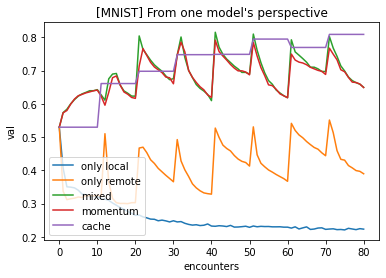

In [113]:
import matplotlib as plot
x = np.arange(len(eval_hist))
temp = np.ones(np.array(eval_hist)[:,1].shape) * 0.82
plt.plot(x, np.array(eval_hist)[:,1])
plt.plot(x, np.array(eval_hist2)[:,1])
plt.plot(x, np.array(eval_hist3)[:,1])
plt.plot(x, np.array(eval_hist4)[:,1])
plt.plot(x, np.array(eval_hist5)[:,1])
# plt.plot(x, np.array(eval_hist6)[:,1])
plt.legend(('only local','only remote', 'mixed', 'momentum', 'cache', 'cache-momentum'),loc='lower left')
plt.title("[MNIST] From one model's perspective")
plt.ylabel("val")
plt.xlabel("encounters")
plt.show()

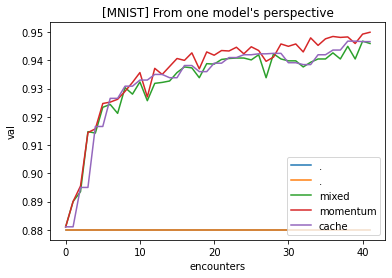

In [98]:
import matplotlib as plot
x = np.arange(len(eval_hist))
temp = np.ones(np.array(eval_hist)[:,1].shape) * 0.88
plt.plot(x, temp)
plt.plot(x, temp)
plt.plot(x, np.array(eval_hist3)[:,1])
plt.plot(x, np.array(eval_hist4)[:,1])
plt.plot(x, np.array(eval_hist5)[:,1])
# plt.plot(x, np.array(eval_hist6)[:,1])
plt.legend(('.','.', 'mixed', 'momentum', 'cache', 'cache-momentum'),loc='lower right')
plt.title("[MNIST] From one model's perspective")
plt.ylabel("val")
plt.xlabel("encounters")
plt.show()

In [141]:
first_exc_locs

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74]

In [119]:
del weights_hist

In [282]:
import plotly.express as px
fig = px.line(x=np.arange(len(eval_hist)), y=np.array(eval_hist)[:,1])
fig.show()

In [272]:
import plotly.express as px
fig = px.line(x=np.arange(len(eval_hist3)), y=np.array(eval_hist3)[:,1])
fig.show()

# ------------------------------------------